## Các bước thực hiện chung

Import thư viện

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import datetime
import time

In [ ]:
!gdown 1ccb2QelkcrNBiJZcG4ADmZOrMoCxrBJz

Downloading...
From: https://drive.google.com/uc?id=1ccb2QelkcrNBiJZcG4ADmZOrMoCxrBJz
To: /content/Iowa_Liquor_Sales_Mining.csv
100% 6.58k/6.58k [00:00<00:00, 21.1MB/s]


Đọc file csv và xử lí các thuộc tính missing

In [ ]:
# đọc file csv
df = pd.read_csv('/content/Iowa_Liquor_Sales_Mining.csv',parse_dates=['Date'])
df1 = pd.DataFrame()
df1['Date'] = df['Date']
df1['Revenue'] = df1['Date'].apply(lambda x: df.loc[df['Date']==x,'Revenue'].values[0]
                                          if df.loc[df['Date']==x,'Revenue'].shape[0] == 1 else None)
# xử lý missing
df1['Revenue'] = df1['Revenue'].interpolate(method='linear')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     307 non-null    datetime64[ns]
 1   Revenue  307 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.9 KB


In [ ]:
df1

,Date,Revenue
0,2022-01-02,7056.61
1,2022-01-03,1428152.44
2,2022-01-04,959250.71
3,2022-01-05,1707491.94
4,2022-01-06,1374753.80
...,...,...
302,2022-12-26,1334072.57
303,2022-12-27,2722392.57
304,2022-12-28,1886654.89
305,2022-12-29,1966377.09


Chia tập dữ liệu thành train - test - val theo tỉ lệ 7:2:1

In [ ]:
from sklearn.model_selection import train_test_split

def split_train_val_test(df, train_size = 0.7, val_size = 0.1, test_size = 0.2):
  train,test = train_test_split(df1,train_size=train_size,shuffle=False)
  val,test = train_test_split(test,train_size= val_size/(1-train_size),shuffle=False)
  return train,val, test

def roll_back(df, lb = 14, hz = 14):
  X,y = np.empty([0,lb]), np.empty([0,hz])
  aset = df['Revenue'].values
  for i in range(len(aset)-lb-hz+1):
    a = aset[i:i+lb].reshape(1,-1)
    b = aset[i+lb:i+lb+hz].reshape(1,-1)
    X = np.append(X,a,axis=0)
    y = np.append(y,b,axis=0)
  return X,y

lookback = 14
horizon = 14
train,val,test = split_train_val_test(df, train_size = 0.7, val_size = 0.1, test_size = 0.2)
X_train,y_train = roll_back(train, lb = lookback, hz = horizon)
X_val,y_val = roll_back(val, lb = lookback, hz = horizon)
X_test,y_test = roll_back(test, lb = lookback, hz = horizon)
X_14days = test.iloc[-14:,1].values.reshape(1,-1)

Tạo lớp visualize để trực quan hóa

In [ ]:
def visualize(test,X_test,y_test,pred_14days):
    plt.figure(figsize=(18,9))
    tmp = pd.DataFrame()
    tmp['Date'] = test['Date'][-28:-14]
    tmp['w'] = X_test[-1]
    plt.plot(tmp.set_index('Date'))

    tmp = pd.DataFrame()
    tmp['Date'] = test['Date'][-14:]
    tmp['gt'] = y_test[-1,:]
    tmp['pd'] = pred_test[-1,:]

    plt.plot(tmp.set_index('Date')['gt'])
    plt.plot(tmp.set_index('Date')['pd'])

    tmp = pd.DataFrame()
    tmp['Date'] = pd.date_range(start = test['Date'].iloc[-1] + pd.DateOffset(days=1) , end = test['Date'].iloc[-1] + pd.DateOffset(days=14))
    tmp['14'] = pred_14days[-1,:]
    plt.plot(tmp.set_index('Date')['14'])

    plt.legend(['Last 14 days','14 days groundtruth','14 days predicted','Next 14 days'])

    plt.show()

Tạo lớp get_metrics để tính toán các độ đo đánh giá

In [ ]:
from sklearn.metrics import *
def get_metrics(g,p):
  print('Kết quả đánh giá:')
  print('MSE:',mean_squared_error(g,p))
  print('RMSE:',np.sqrt(mean_squared_error(g,p)))
  print('MAE:',mean_absolute_error(g,p))
  print('MAPE:',mean_absolute_percentage_error(g,p))
  print('R2:',r2_score(g,p))

### **Linear Regression**

Huấn luyện mô hình Linear Regression

In [ ]:
# định nghĩa mô hình
model_LR = LinearRegression()

# train mô hình
model_LR.fit(X_train,y_train)

# dự đoán trên tập val và tập test
pred_val = model_LR.predict(X_val)
pred_test = model_LR.predict(X_test)

# tính độ đo đánh giá
print('Validation set')
get_metrics(pred_val,y_val)

print('\nTest set')
get_metrics(pred_test,y_test)

Validation set
Kết quả đánh giá:
MSE: 635614164422.9568
RMSE: 797254.1404238405
MAE: 629521.8185804301
MAPE: 0.5088849416780951
R2: -86.94772956281979

Test set
Kết quả đánh giá:
MSE: 537896724570.8536
RMSE: 733414.4289355463
MAE: 569581.0940894993
MAPE: 0.5637232995865583
R2: -1.544475219850656


Dự đoán 14 ngày tiếp theo

In [ ]:
pred_14days_LR = model_LR.predict(X_14days)

In [ ]:
pred_14days_LR

array([[ 293820.4590301 , 1207461.49203984, 2424923.30638195,
        1873527.92259582, 1685600.56691825, 1431513.98608063,
         420687.52550366, 1309572.80254484, 2263094.39992496,
        1661081.27474799, 1518206.27027284, 1197188.86721552,
         682470.37029572, 1513603.73741713]])

Trực quan hóa dữ liệu

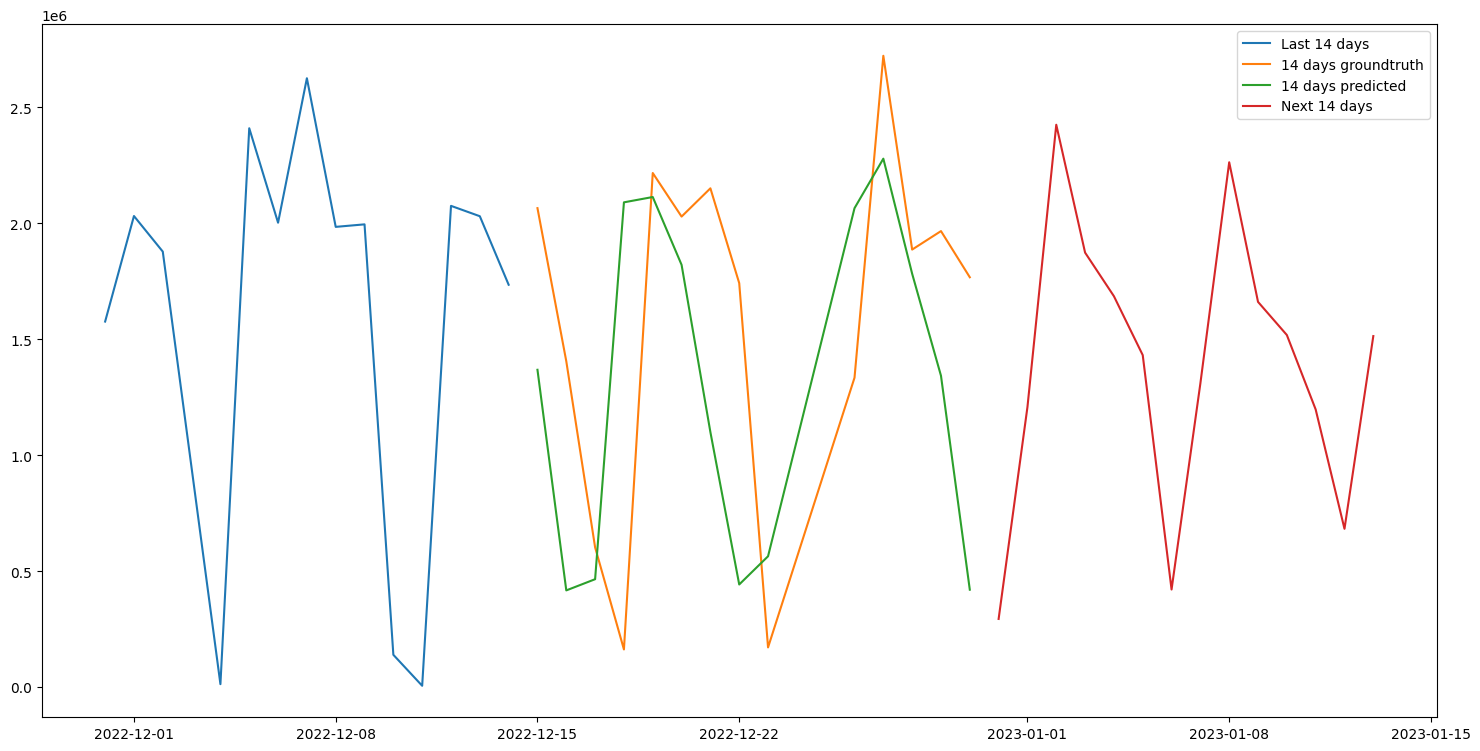

In [ ]:
visualize(test,X_test,y_test,pred_14days_LR)

### **Random Forest Regression**


Huấn luyện mô hình mô hình Random Forest Regressor

In [ ]:
# định nghĩa mô hình
model_RF = RandomForestRegressor(n_estimators = 30, random_state=42)

# train mô hình
model_RF.fit(X_train,y_train)

RandomForestRegressor(n_estimators=30, random_state=42)

In [ ]:
# dự đoán trên tập val và tập test
pred_val = model_RF.predict(X_val)
pred_test = model_RF.predict(X_test)

# tính độ đo đánh giá
print('Validation set')
get_metrics(pred_val,y_val)

print('\nTest set')
get_metrics(pred_test,y_test)

Validation set
Kết quả đánh giá:
MSE: 582586214697.8394
RMSE: 763273.3551604166
MAE: 584484.8598928571
MAPE: 0.44303517584939967
R2: -18.84669545085101

Test set
Kết quả đánh giá:
MSE: 562294631473.5773
RMSE: 749863.0751501085
MAE: 608256.2308693879
MAPE: 0.5095326281893264
R2: -3.635082399047374


Dự đoán 14 ngày tiếp theo

In [ ]:
pred_14days_RF = model_RF.predict(X_14days)

In [ ]:
pred_14days_RF

array([[ 164971.94733333, 1663335.48466667, 1630481.37666667,
        1973698.68733333, 1798455.783     , 1528475.80466667,
         413555.10833333, 1674781.35033333, 1833902.52233333,
        1862620.30433333, 1652300.39233333, 1145226.339     ,
         752259.10933333, 1707000.17066667]])

Trực quan hóa dữ liệu

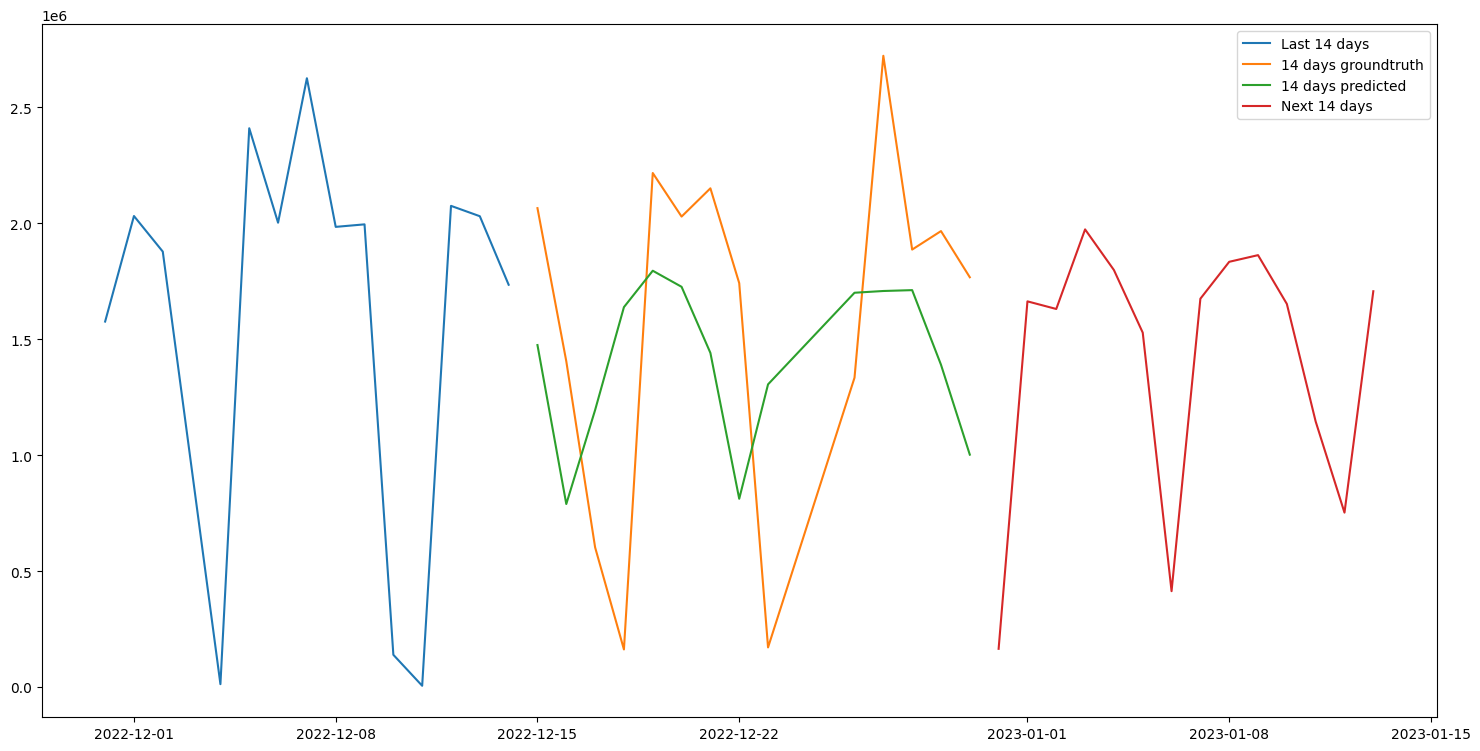

In [ ]:
visualize(test,X_test,y_test,pred_14days_RF)